In [1]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
from scipy.stats import kurtosis
from notebook_helper import reload_notebook_cell, generate_seed



# Generate Data

In [2]:
from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_raisin_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder
reload_notebook_cell()

X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()
X_train_raisin, X_test_raisin, y_train_raisin, y_test_raisin = get_and_preprocess_raisin_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)
y_train_encode_raisin, y_test_encode_raisin, label_encoder_raisin = y_label_encode(y_train_raisin, y_test_raisin)


c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


### PCA + KMEANS 

Using best components from previous step

* Best number of components for SDAS dataset: 154
* Best number of components for Raisin dataset: 3

In [3]:
reload_notebook_cell()
best_n_components_pca_sdas = 154
best_n_components_pca_raisin = 3

# Fit PCA for SDAS dataset
pca_sdas_comp = pipelines.PCA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_pca_sdas, random_state=42).fit_transform(X_train_sdas)
pca_raisin_comp = pipelines.PCA_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_pca_raisin, random_state=42).fit_transform(X_train_raisin)


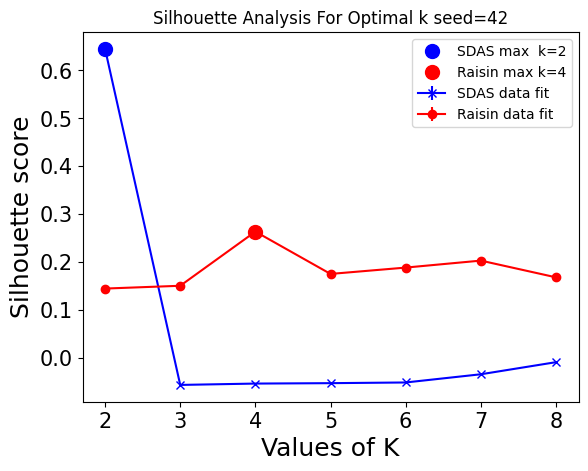

Max  silhouette score for SDAS data: 0.6447422682134618 at k=2
Max  silhouette score for Raisin data: 0.2636403356443182 at k=4


In [37]:
reload_notebook_cell()

range_n_clusters, \
mean_silhouette_sdas, \
std_silhouette_sdas, \
mean_silhouette_raisin, \
std_silhouette_raisin, \
max_mean_sdas_score, \
max_mean_sdas_k, \
max_mean_raisin_score, max_mean_raisin_k = pipeline_helpers.get_silhouette_scores((pca_sdas_comp, pca_raisin_comp),[], 42)

# Plot the mean and standard deviation
# Highlight the maximum mean silhouette score points

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis For Optimal k seed=42")
plt.legend()
plt.show()



print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

# source https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/


In [35]:
# get the clusters for the optimimal k for sdas and raisin
kmeans_sdas = pipelines.KMeans_pipeline(pca_sdas_comp,n_clusters=max_mean_sdas_k, random_state=42).fit(pca_sdas_comp)
kmeans_raisin = pipelines.KMeans_pipeline(pca_raisin_comp,n_clusters=max_mean_raisin_k, random_state=42).fit(pca_raisin_comp)
kmeans_pca_labels_raisin = kmeans_raisin['classifier'].labels_
kmeans_pca_labels_sdas    = kmeans_sdas['classifier'].labels_

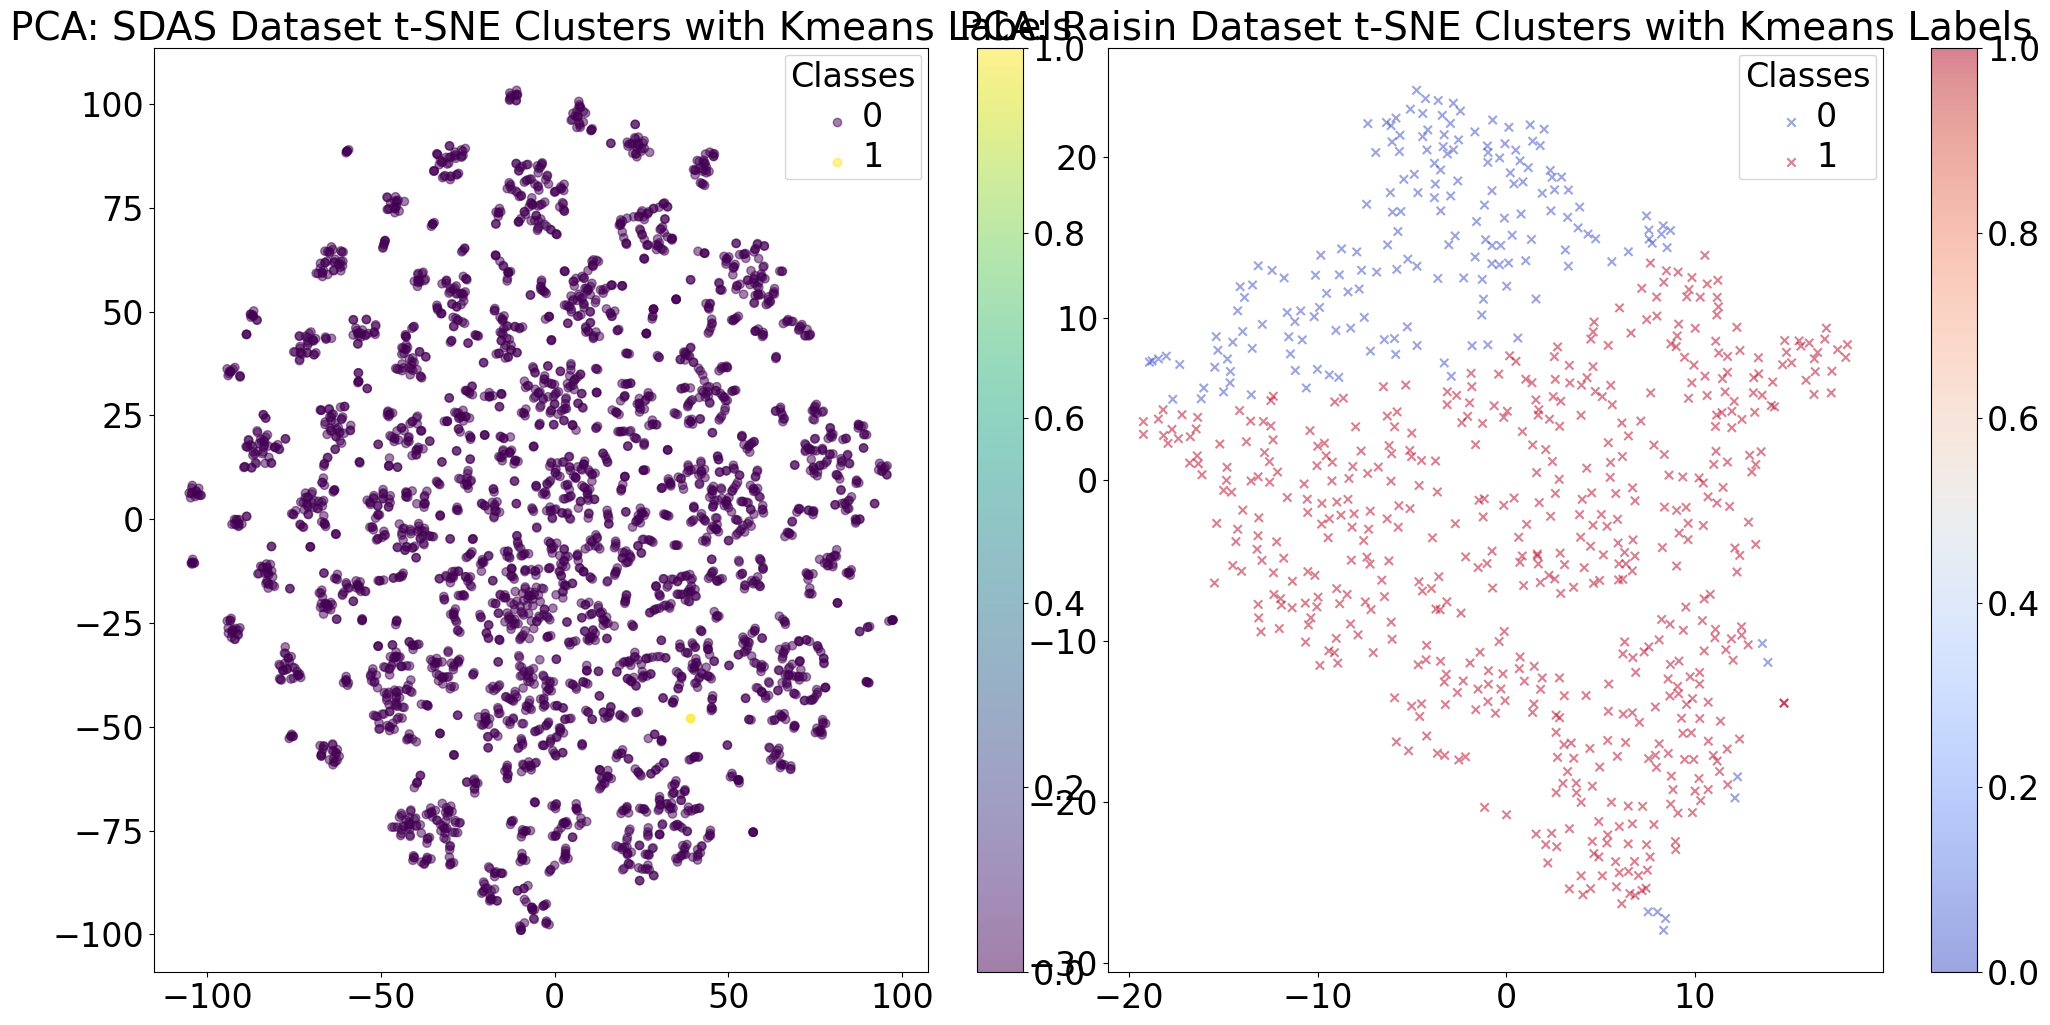

In [47]:
reload_notebook_cell()

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(pca_sdas_comp, list_of_categories=[], **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(pca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(pca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(pca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("PCA: SDAS Dataset t-SNE Clusters with Kmeans Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=kmeans_pca_labels_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(kmeans_pca_labels_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("PCA: Raisin Dataset t-SNE Clusters with Kmeans Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=kmeans_pca_labels_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(kmeans_pca_labels_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(plt, label_fontsize=16, title_fontsize=16*1.1, legend_fontsize=12*1.3, tick_fontsize=12*1.3, constant=1.6)
plt.show()

## RP + Kmeans


Using best components from previous step

* Best number of components for SDAS dataset: 186
* Best number of components for Raisin dataset: 5

In [161]:
# Fit PCA for SDAS dataset
best_n_components_rca_sdas = 186
best_n_components_rca_raisin = 5
rca_sdas_comp = pipelines.GaussianRP_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_rca_sdas, random_state=42).fit_transform(X_train_sdas)
rca_raisin_comp = pipelines.GaussianRP_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_rca_raisin, random_state=42).fit_transform(X_train_raisin)

Max  silhouette score for SDAS data: 0.6553120857736664 at k=2
Max  silhouette score for Raisin data: 0.5382411859961754 at k=2


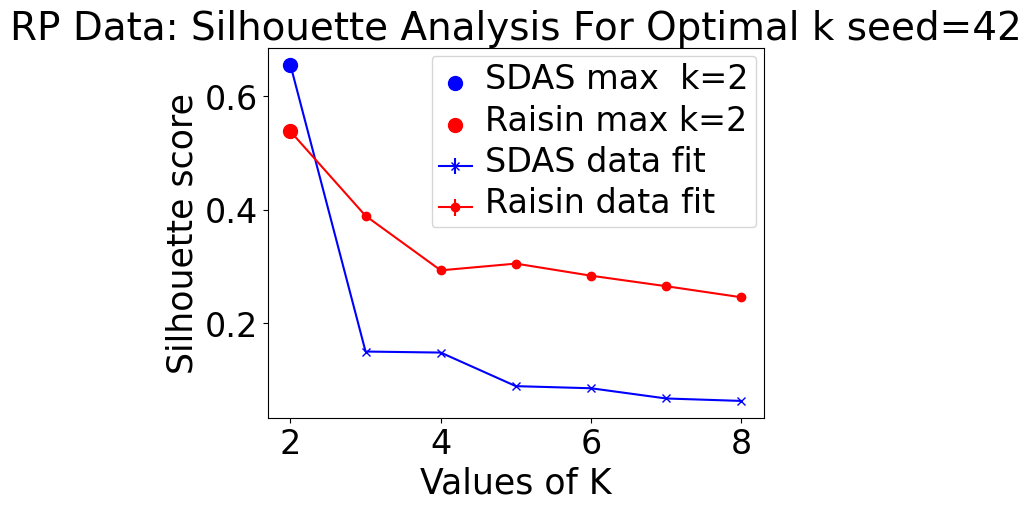

In [162]:
reload_notebook_cell()

range_n_clusters, \
mean_silhouette_sdas, \
std_silhouette_sdas, \
mean_silhouette_raisin, \
std_silhouette_raisin, \
max_mean_sdas_score, \
max_mean_sdas_k, \
max_mean_raisin_score, max_mean_raisin_k = pipeline_helpers.get_silhouette_scores((rca_sdas_comp, rca_raisin_comp),[], 42)

# Plot the mean and standard deviation
# Highlight the maximum mean silhouette score points

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("RP Data: Silhouette Analysis For Optimal k seed=42")
plt.legend()
helpers.increase_font_size_subplots_included(plt, label_fontsize=16, title_fontsize=16*1.1, legend_fontsize=12*1.3, tick_fontsize=12*1.3, constant=1.6)
print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

In [163]:
reload_notebook_cell()
# get the clusters for the optimimal k for sdas and raisin
kmeans_sdas = pipelines.KMeans_pipeline(rca_sdas_comp,n_clusters=max_mean_sdas_k, random_state=42).fit(rca_sdas_comp)
kmeans_raisin = pipelines.KMeans_pipeline(rca_raisin_comp,n_clusters=max_mean_raisin_k, random_state=42).fit(rca_raisin_comp)
kmeans_pca_labels_raisin = kmeans_raisin['classifier'].labels_
kmeans_pca_labels_sdas    = kmeans_sdas['classifier'].labels_

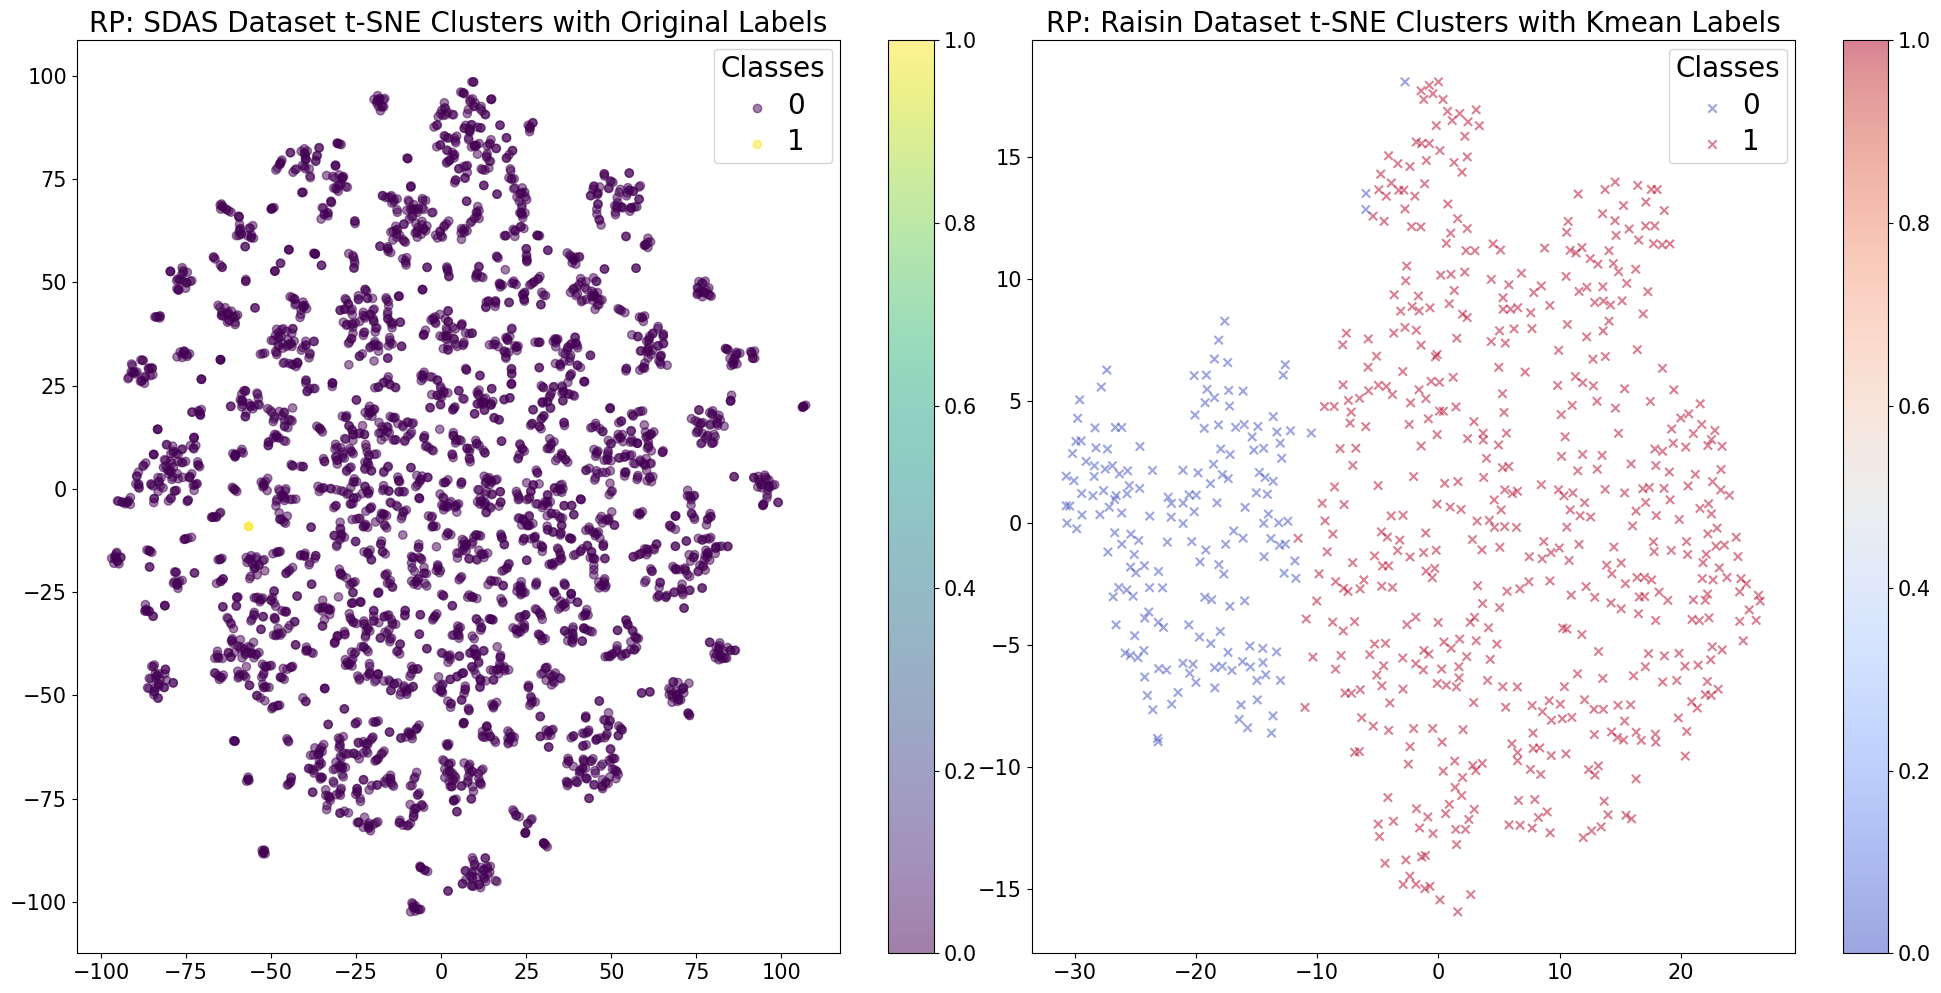

In [164]:
# Visualize clusters vs original labels using t-SNE
reload_notebook_cell()

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(rca_sdas_comp, list_of_categories=[], **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(rca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(rca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(rca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("RP: SDAS Dataset t-SNE Clusters with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=kmeans_pca_labels_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(kmeans_pca_labels_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("RP: Raisin Dataset t-SNE Clusters with Kmean Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=kmeans_pca_labels_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(kmeans_pca_labels_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
# helpers.increase_font_size_subplots_included(plt, label_fontsize=16, title_fontsize=16*1.1, legend_fontsize=12*1.3, tick_fontsize=12*1.3, constant=1.6)
helpers.increase_font_size_subplots_included(plt)
plt.show()

## ICA + Kmeans


Using best components from previous step

* Best number of components for SDAS dataset: 6
* Best number of components for Raisin dataset: 2

* Best perplexity SDAS: 50
* Best perplexity Raisin: 50

In [50]:
# Fit PCA for SDAS dataset
ica_sdas_comp = pipelines.ICA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=6, random_state=42).fit_transform(X_train_sdas)
ica_raisin_comp = pipelines.ICA_pipeline(X_train_raisin, list_of_categories=[], n_components=2, random_state=42).fit_transform(X_train_raisin)

Max  silhouette score for SDAS data: 0.3689858590345489 at k=4
Max  silhouette score for Raisin data: 0.885563453246691 at k=2


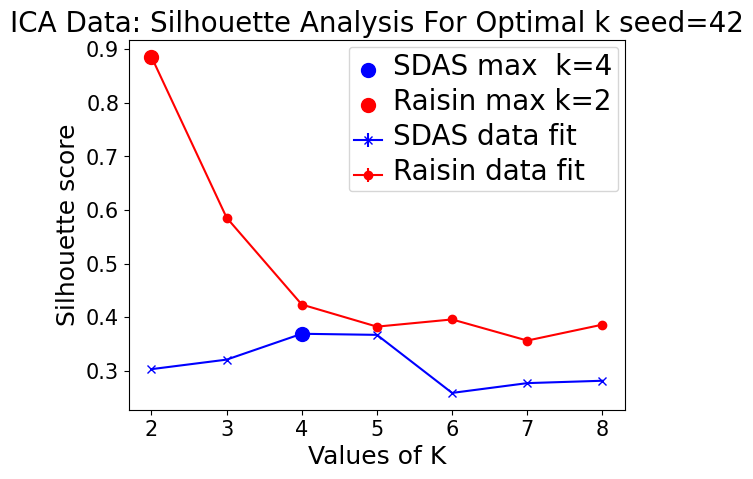

In [55]:
reload_notebook_cell()

range_n_clusters, \
mean_silhouette_sdas, \
std_silhouette_sdas, \
mean_silhouette_raisin, \
std_silhouette_raisin, \
max_mean_sdas_score, \
max_mean_sdas_k, \
max_mean_raisin_score, max_mean_raisin_k = pipeline_helpers.get_silhouette_scores((ica_sdas_comp, ica_raisin_comp),[], 42)

# Plot the mean and standard deviation
# Highlight the maximum mean silhouette score points

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("ICA Data: Silhouette Analysis For Optimal k seed=42")
plt.legend()
helpers.increase_font_size_subplots_included(plt)
print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

In [61]:
kmeans_sdas = pipelines.KMeans_pipeline(ica_sdas_comp,n_clusters=max_mean_sdas_k, random_state=42).fit(rca_sdas_comp)
kmeans_raisin = pipelines.KMeans_pipeline(ica_raisin_comp,n_clusters=max_mean_raisin_k, random_state=42).fit(rca_raisin_comp)
kmeans_ica_labels_raisin = kmeans_raisin['classifier'].labels_
kmeans_ica_labels_sdas    = kmeans_sdas['classifier'].labels_

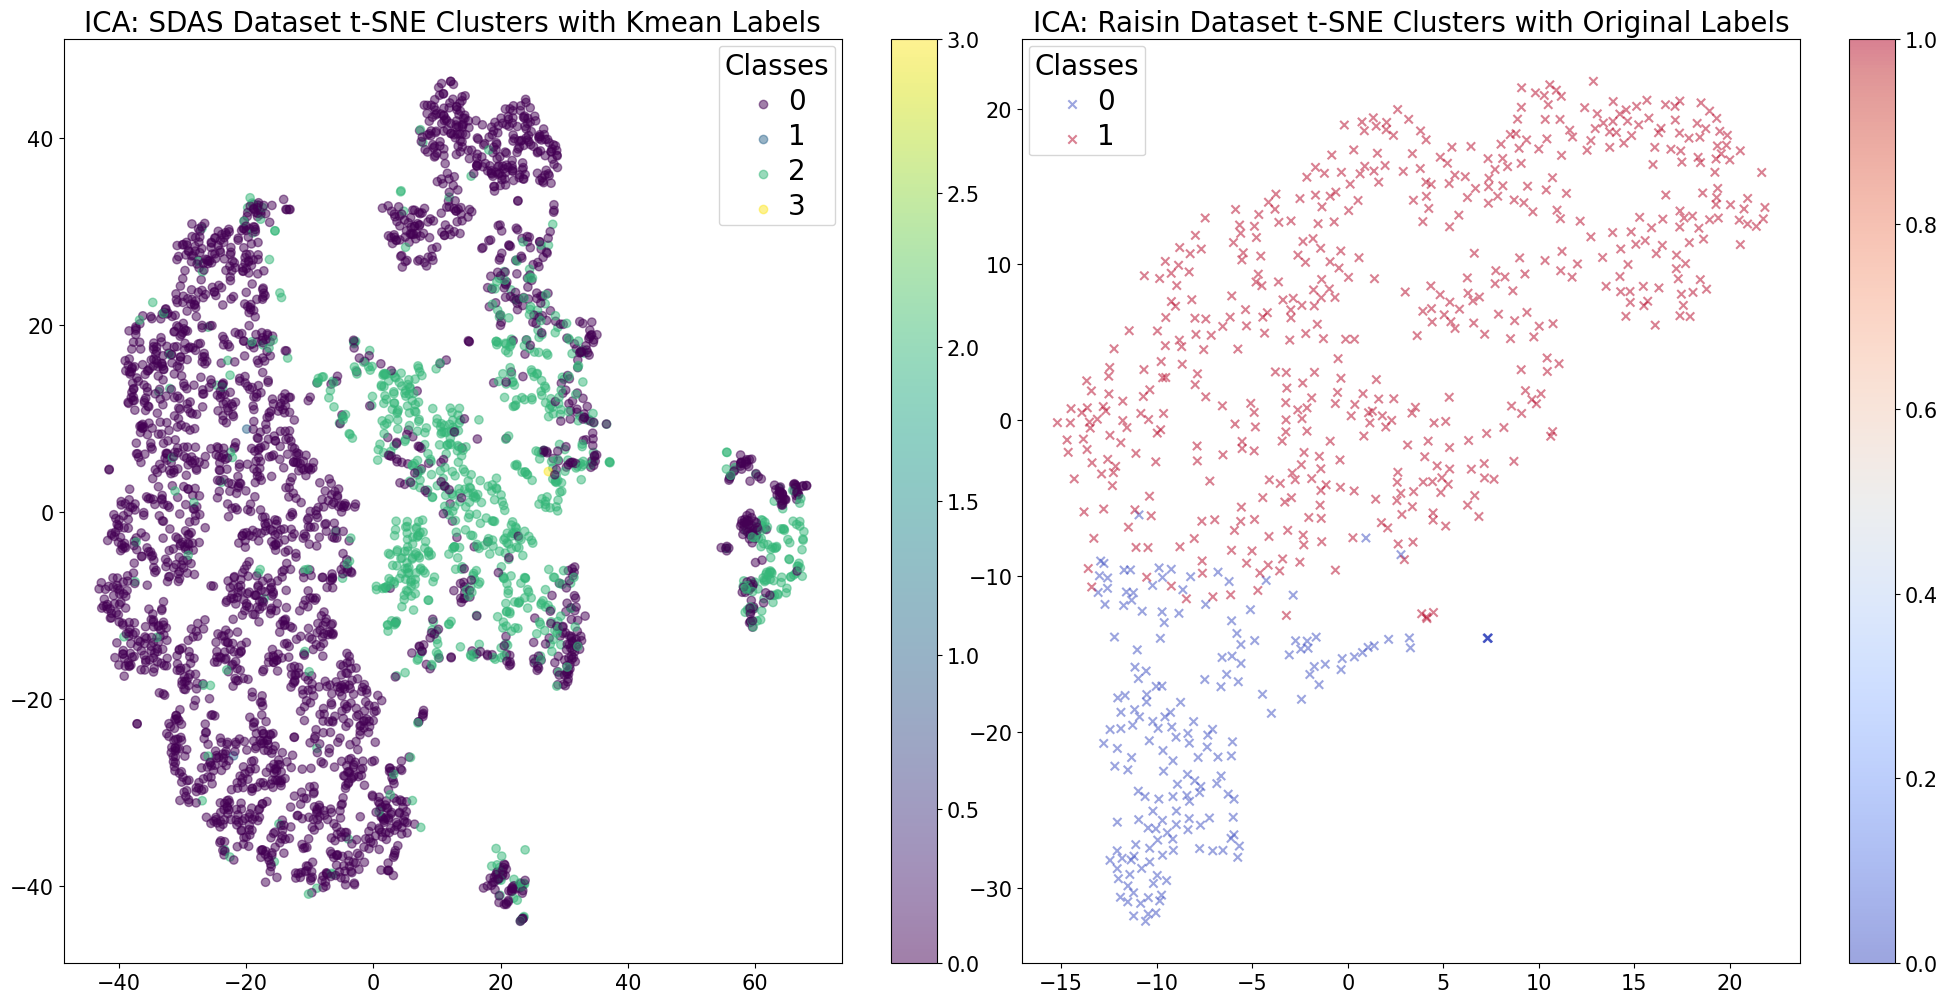

In [59]:
reload_notebook_cell()

# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(ica_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(ica_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(ica_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(ica_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("ICA: SDAS Dataset t-SNE Clusters with Kmean Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=kmeans_ica_labels_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(kmeans_ica_labels_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("ICA: Raisin Dataset t-SNE Clusters with Kmeans Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=kmeans_ica_labels_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(kmeans_ica_labels_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(plt)
plt.show()

## PCA + EM

In [142]:
reload_notebook_cell()
best_n_components_pca_sdas = 154
best_n_components_pca_raisin = 3

# Fit PCA for SDAS dataset
pca_sdas_comp = pipelines.PCA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_pca_sdas, random_state=42).fit_transform(X_train_sdas)
pca_raisin_comp = pipelines.PCA_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_pca_raisin, random_state=42).fit_transform(X_train_raisin)

Best parameters for SDAS: {'classifier__covariance_type': 'diag', 'classifier__n_components': 6}
Min BIC score for SDAS: 232864.0046476542
Best parameters for Raisin: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 2}
Min BIC score for Raisin: 1233.3290175502311


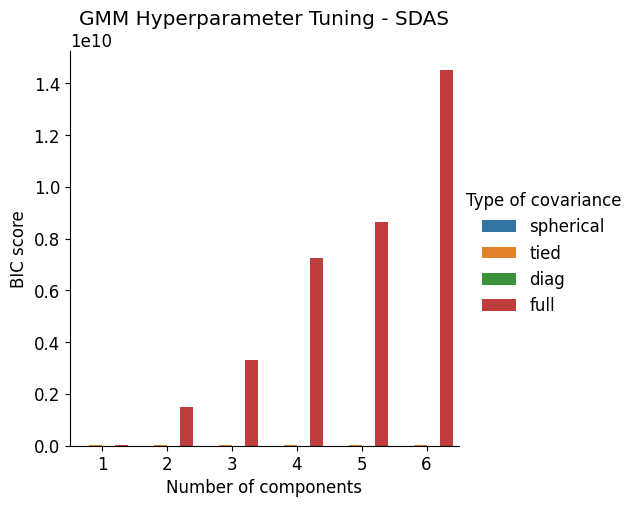

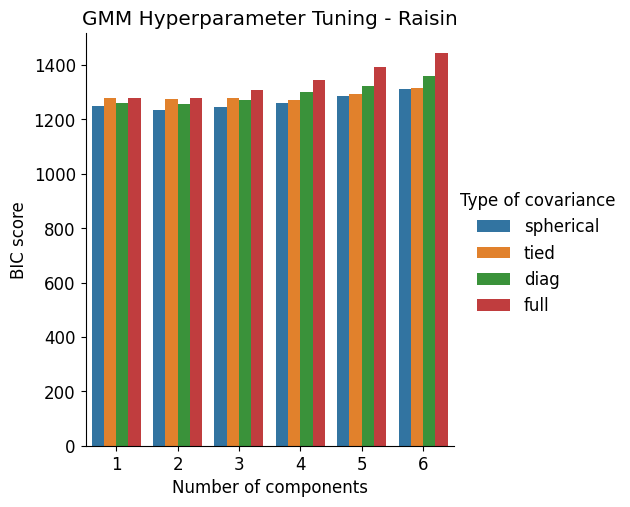

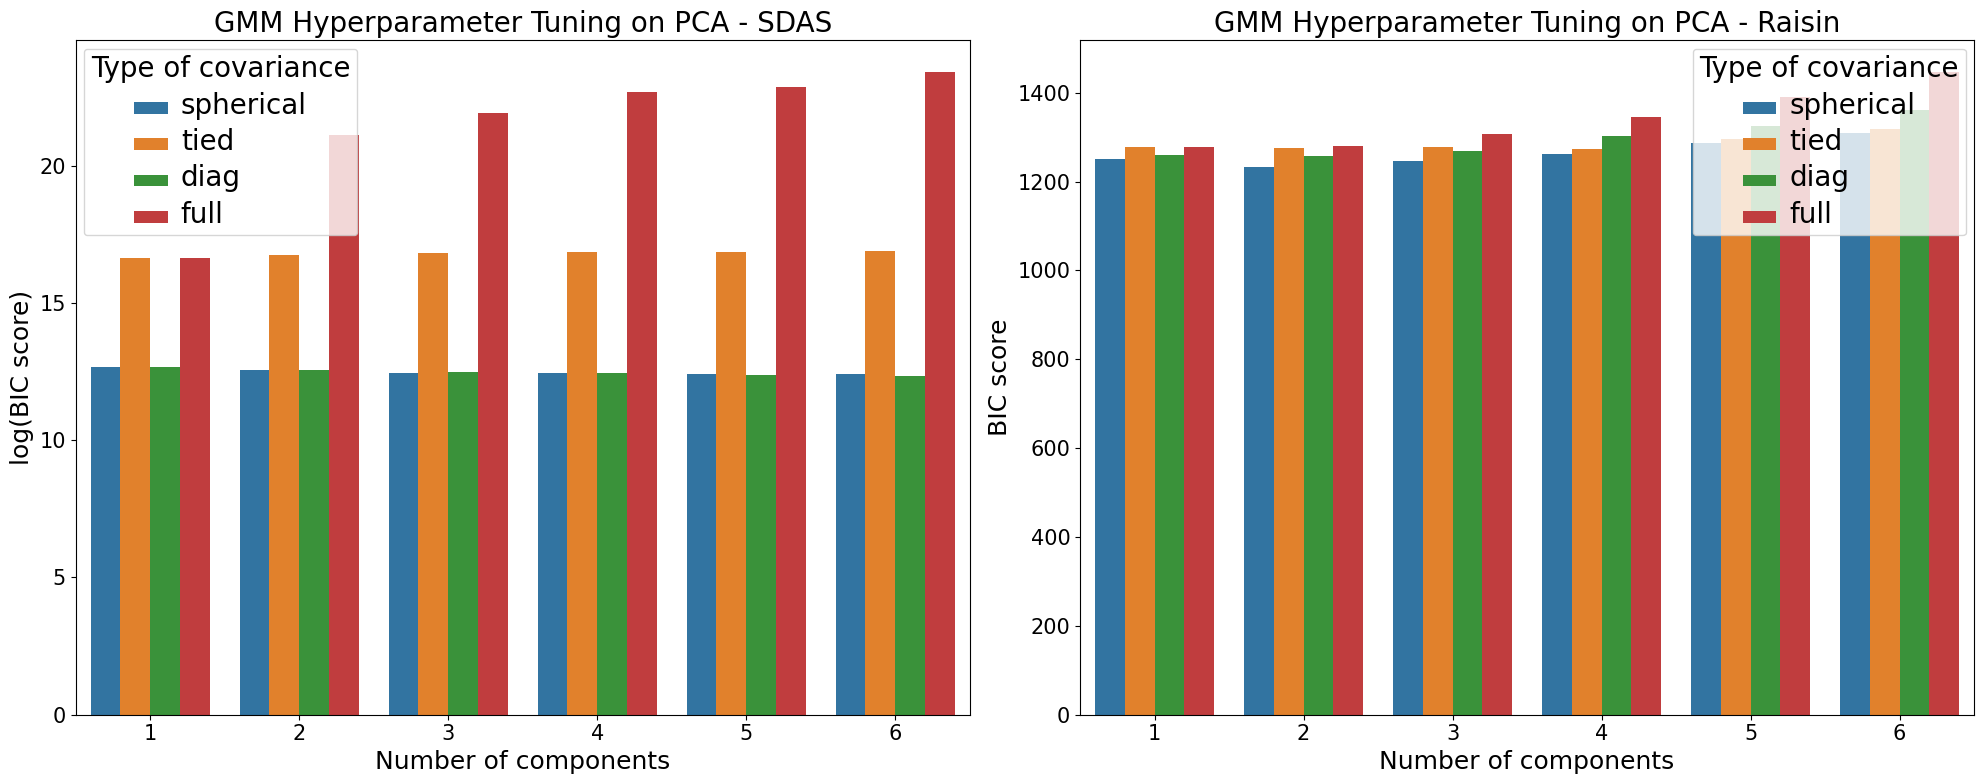

Best parameters for SDAS: {'classifier__covariance_type': 'diag', 'classifier__n_components': 6}
Min BIC score for SDAS: 232864.0046476542
Best parameters for Raisin: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 2}
Min BIC score for Raisin: 1233.3290175502311


In [143]:
reload_notebook_cell()



# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = pipeline_helpers.grid_search_gmm(pca_sdas_comp, CATEGORY_COLUMNS_UCML, "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = pipeline_helpers.grid_search_gmm(pca_raisin_comp, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_sdas["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning on PCA - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning on PCA - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(plt)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

In [144]:
reload_notebook_cell()
## train the best model for SDAS and Raisin
# Fit GMM for SDAS dataset
best_gmm_sdas = pipelines.GMM_pipeline(pca_sdas_comp, CATEGORY_COLUMNS_UCML, n_components=best_params_sdas['classifier__n_components'], covariance_type=best_params_sdas['classifier__covariance_type'], random_state=42).fit(pca_sdas_comp)
best_gmm_raisin = pipelines.GMM_pipeline(pca_raisin_comp, [], n_components=best_params_raisin['classifier__n_components'], covariance_type=best_params_raisin['classifier__covariance_type'], random_state=42).fit(pca_raisin_comp)

# get the labels for the best model
gmm_labels_sdas_labels = best_gmm_sdas['classifier'].predict(pca_sdas_comp)
gmm_labels_raisin_labels = best_gmm_raisin['classifier'].predict(pca_raisin_comp)

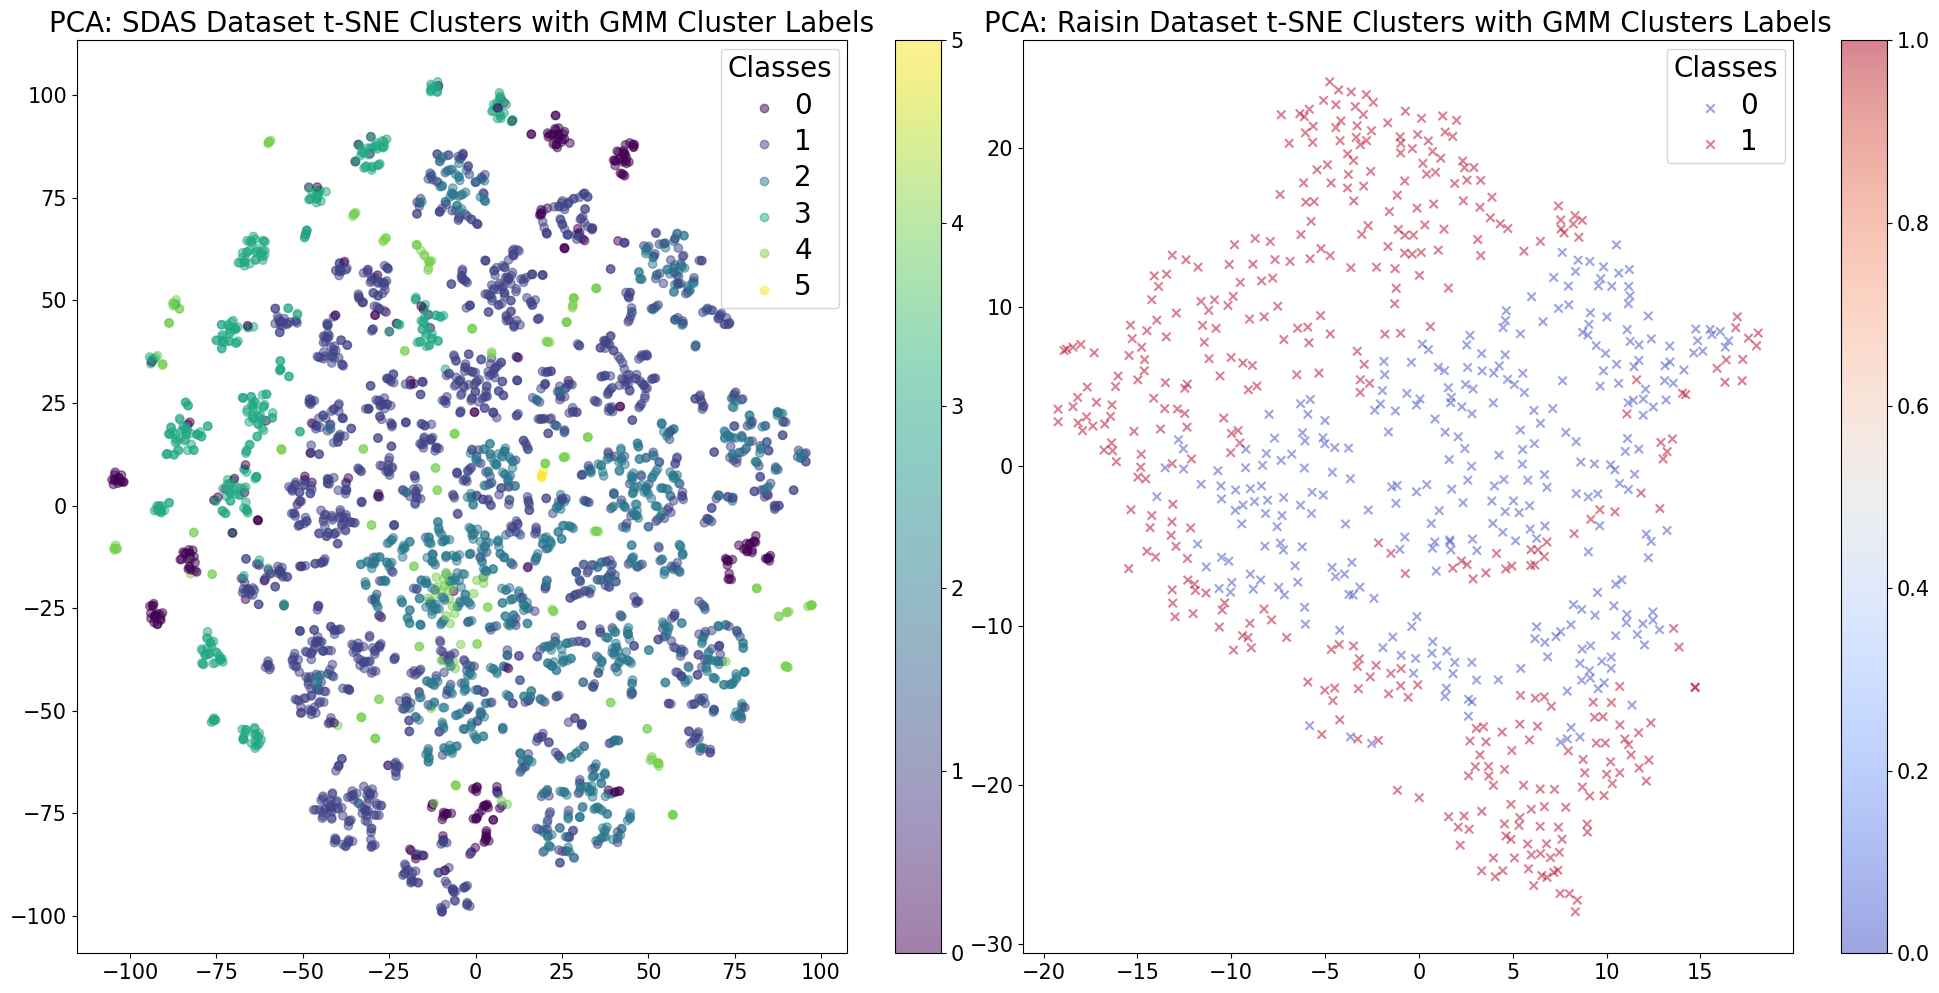

In [146]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(pca_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(pca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(pca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(pca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("PCA: SDAS Dataset t-SNE Clusters with GMM Cluster Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=gmm_labels_sdas_labels, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(gmm_labels_sdas_labels)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("PCA: Raisin Dataset t-SNE Clusters with GMM Clusters Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=gmm_labels_raisin_labels, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(gmm_labels_raisin_labels)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt) 
plt.show()

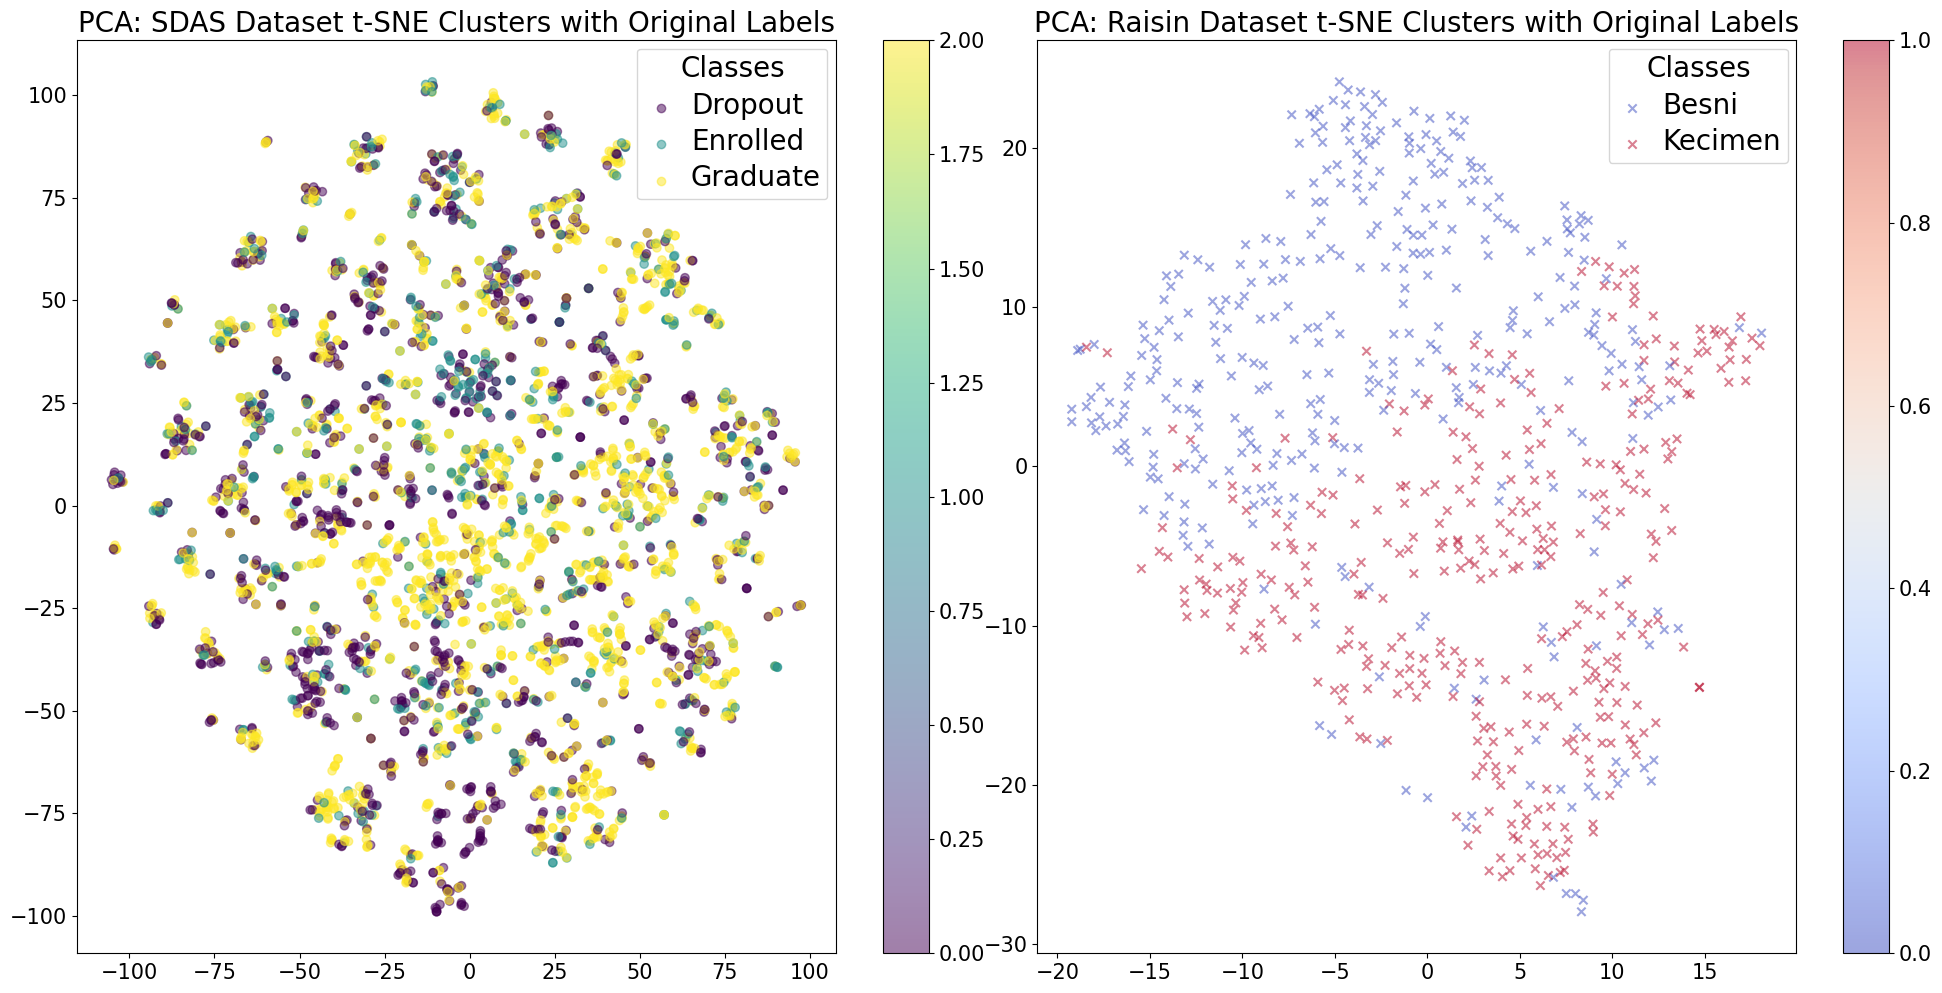

(1,
 Class    Kecimen
 Name: 10, dtype: object)

In [157]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(pca_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(pca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(pca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(pca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("PCA: SDAS Dataset t-SNE Clusters with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(y_train_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("PCA: Raisin Dataset t-SNE Clusters with Original Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(y_train_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt) 
plt.show()



## RP + EM

In [165]:
reload_notebook_cell()
best_n_components_rp_sdas = 186
best_n_components_rp_raisin = 5

# Fit PCA for SDAS dataset
rp_sdas_comp = pipelines.GaussianRP_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_rp_sdas, random_state=42).fit_transform(X_train_sdas)
rp_raisin_comp = pipelines.GaussianRP_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_rp_raisin, random_state=42).fit_transform(X_train_raisin)



Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 5}
Min BIC score for SDAS: 287397.0777821023
Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 2}
Min BIC score for Raisin: 339.15217760430687


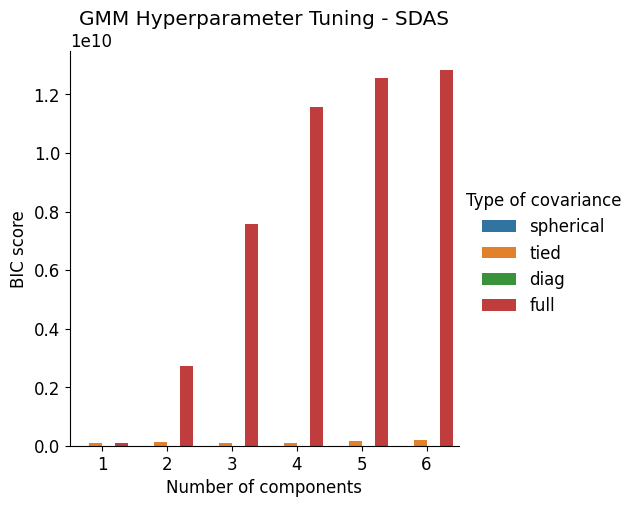

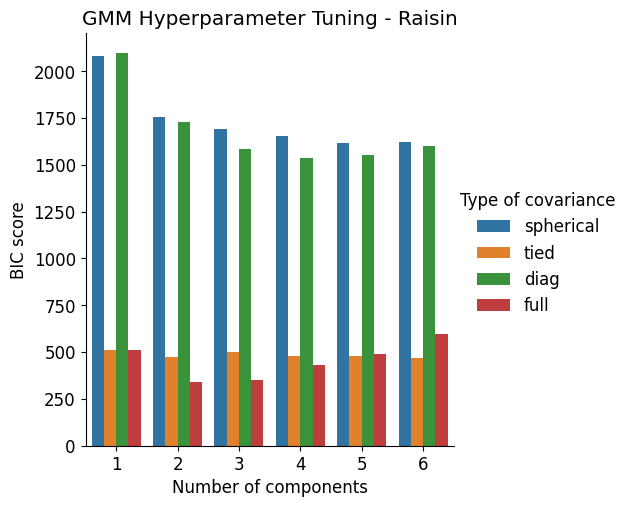

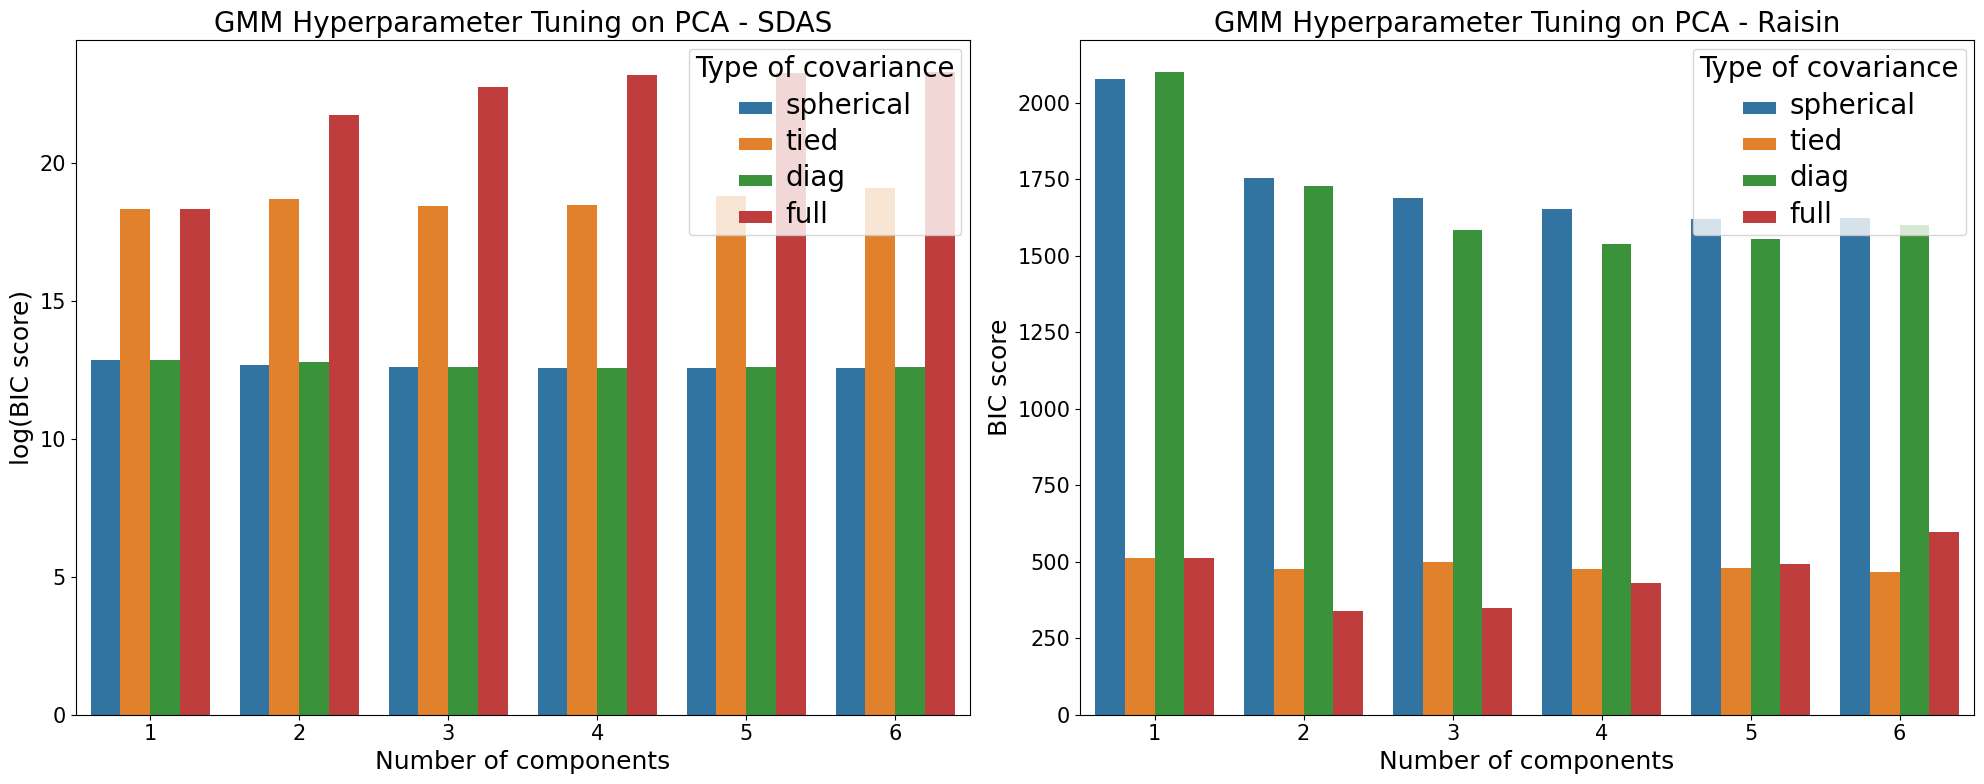

Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 5}
Min BIC score for SDAS: 287397.0777821023
Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 2}
Min BIC score for Raisin: 339.15217760430687


In [166]:
reload_notebook_cell()



# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = pipeline_helpers.grid_search_gmm(rp_sdas_comp, [], "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = pipeline_helpers.grid_search_gmm(rp_raisin_comp, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_raisin["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning on PCA - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning on PCA - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(plt)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

In [167]:
reload_notebook_cell()
# get the labels for the best model
best_gmm_sdas = pipelines.GMM_pipeline(rp_sdas_comp, CATEGORY_COLUMNS_UCML, n_components=best_params_sdas['classifier__n_components'], covariance_type=best_params_sdas['classifier__covariance_type'], random_state=42).fit(rp_sdas_comp)
best_gmm_raisin = pipelines.GMM_pipeline(rp_raisin_comp, [], n_components=best_params_raisin['classifier__n_components'], covariance_type=best_params_raisin['classifier__covariance_type'], random_state=42).fit(rp_raisin_comp)
gmm_labels_sdas_labels = best_gmm_sdas['classifier'].predict(rp_sdas_comp)
gmm_labels_raisin_labels = best_gmm_raisin['classifier'].predict(rp_raisin_comp)

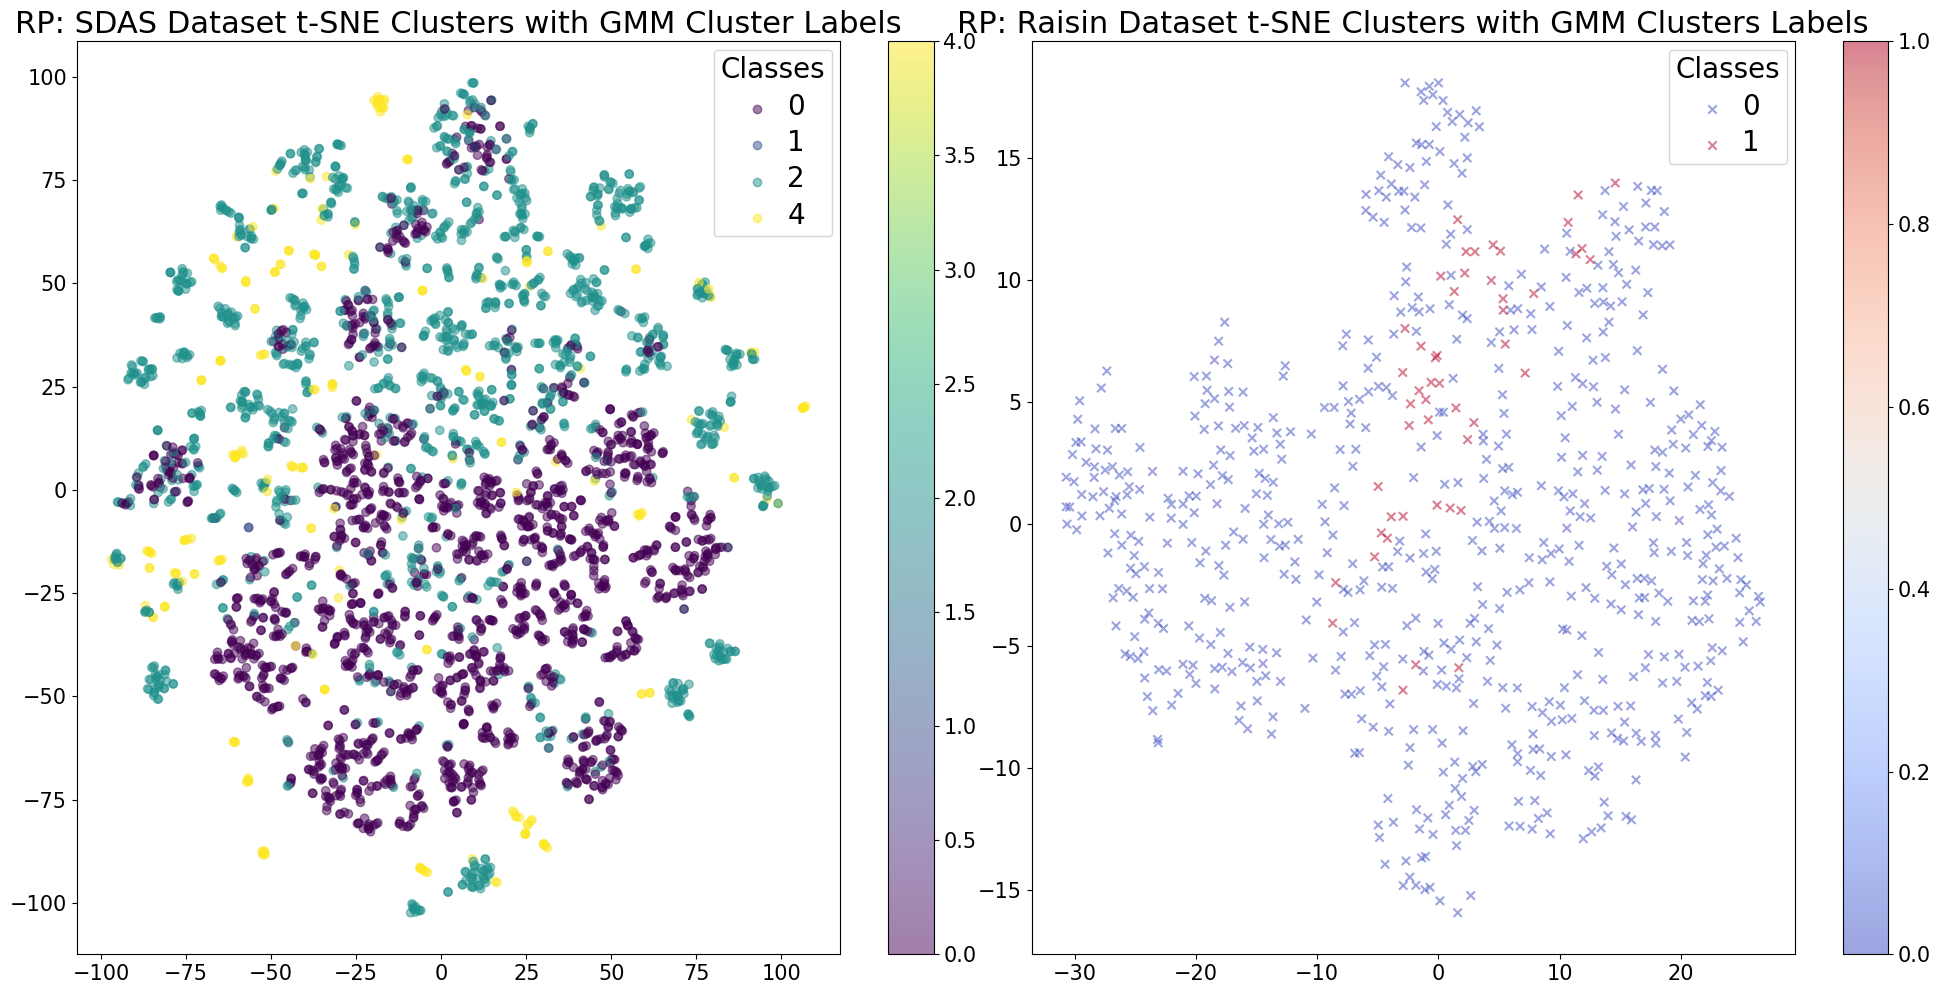

In [168]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(rp_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(rp_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(rp_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(rp_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("RP: SDAS Dataset t-SNE Clusters with GMM Cluster Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=gmm_labels_sdas_labels, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(gmm_labels_sdas_labels)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("RP: Raisin Dataset t-SNE Clusters with GMM Clusters Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=gmm_labels_raisin_labels, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(gmm_labels_raisin_labels)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt,
    15,
    17,
    12 * 1.34,
    12,
    1.3
) 
plt.show()

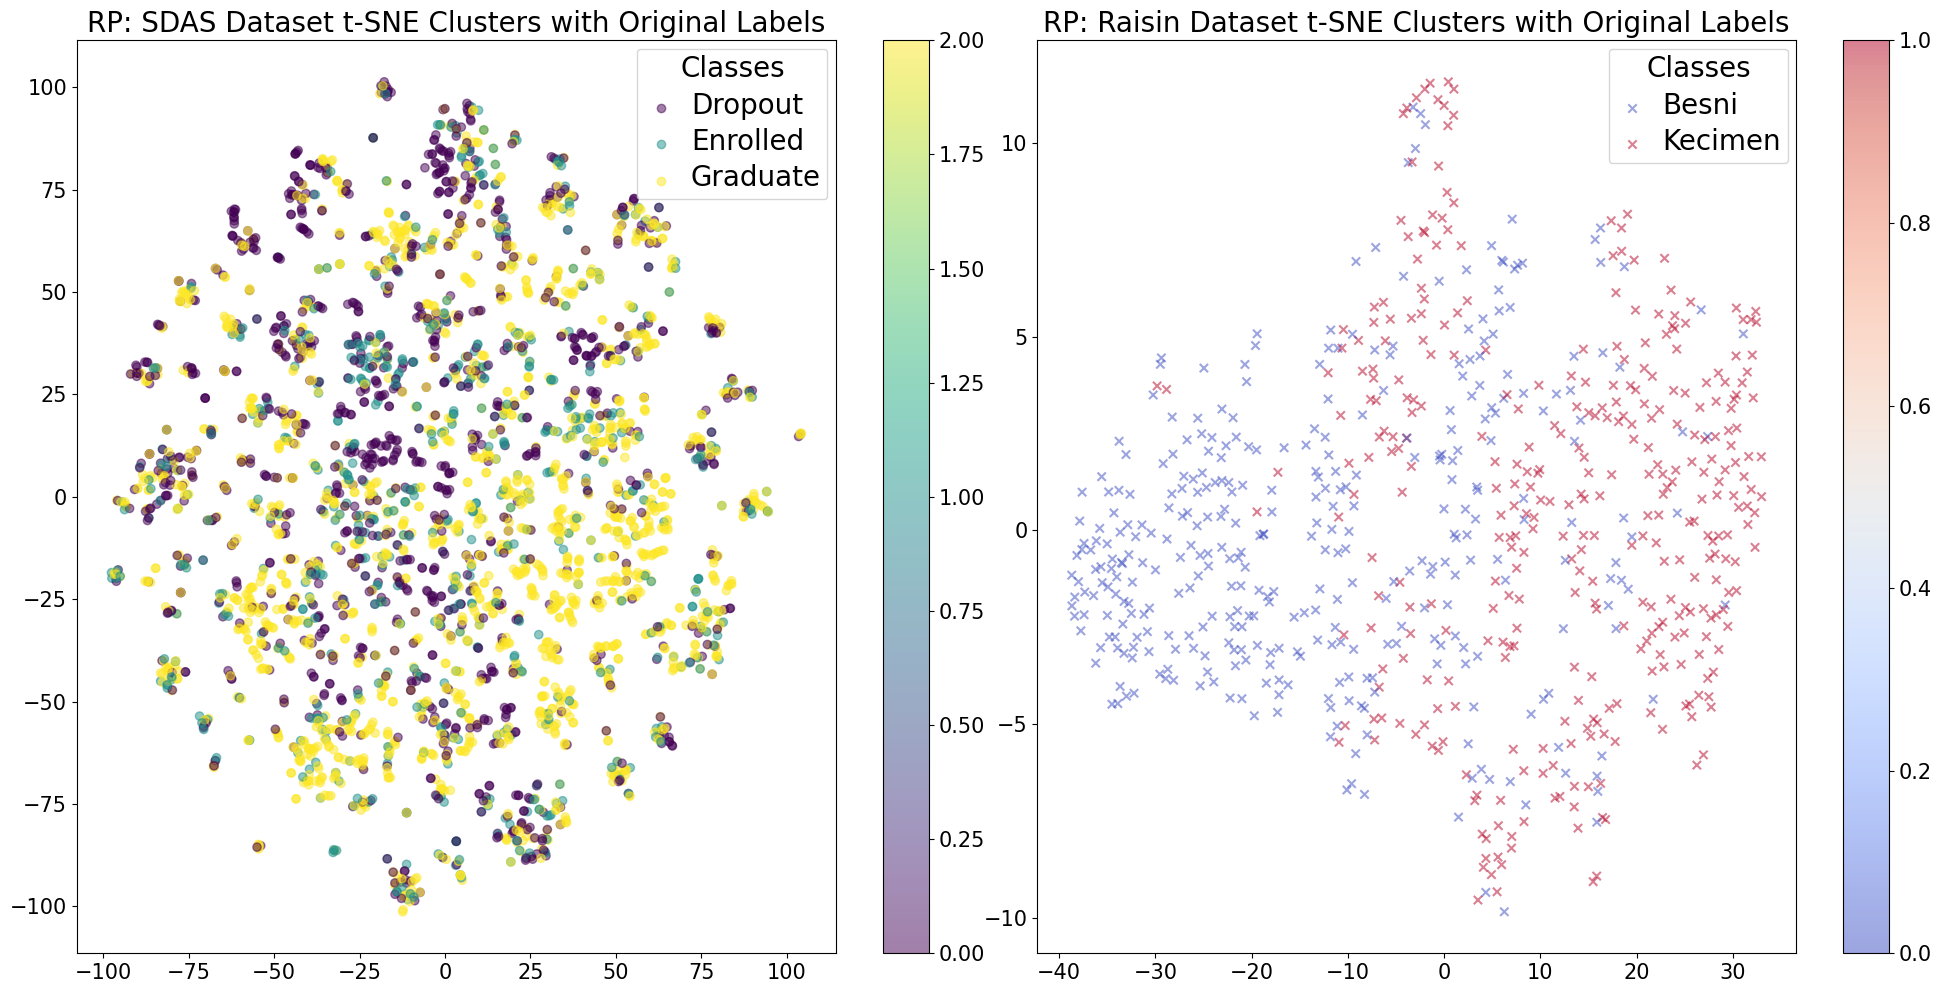

In [159]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(rp_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(rp_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(rp_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform( rp_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("RP: SDAS Dataset t-SNE Clusters with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(y_train_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("RP: Raisin Dataset t-SNE Clusters with Original Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(y_train_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt) 
plt.show()


## ICA + EM

In [131]:
reload_notebook_cell()

best_n_components_ica_sdas = 6
best_n_components_ica_raisin = 2

# Fit PCA for SDAS dataset
ica_sdas_comp = pipelines.ICA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_ica_sdas, whiten='unit-variance', random_state=42).fit_transform(X_train_sdas)
ica_raisin_comp = pipelines.ICA_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_ica_raisin, whiten='unit-variance', random_state=42).fit_transform(X_train_raisin)

Best parameters for SDAS: {'classifier__covariance_type': 'full', 'classifier__n_components': 6}
Min BIC score for SDAS: 898.4339998202656
Best parameters for Raisin: {'classifier__covariance_type': 'diag', 'classifier__n_components': 3}
Min BIC score for Raisin: 571.0538582096322


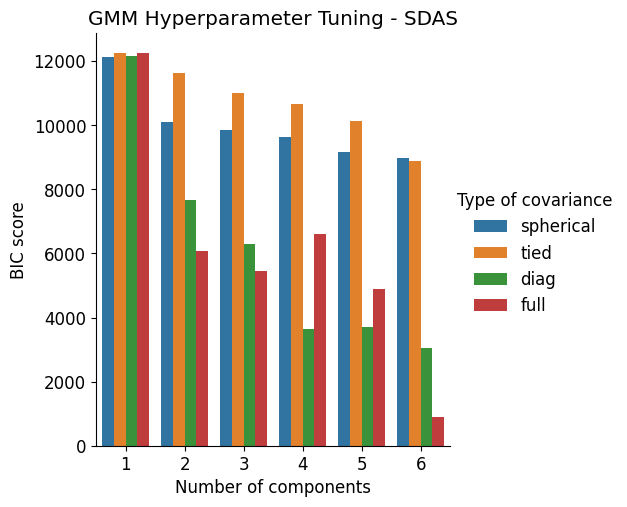

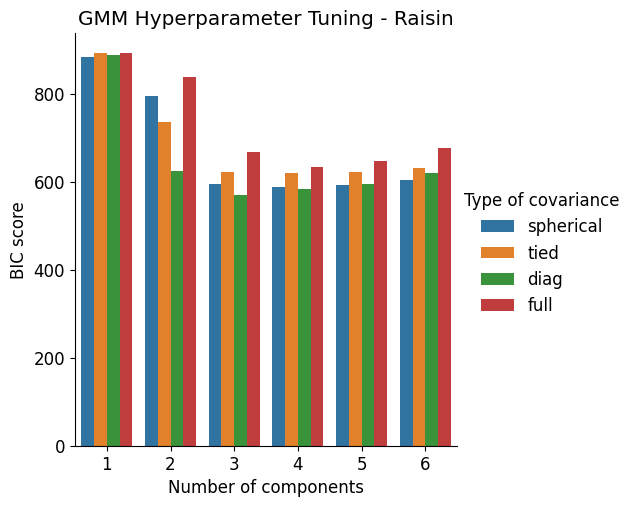

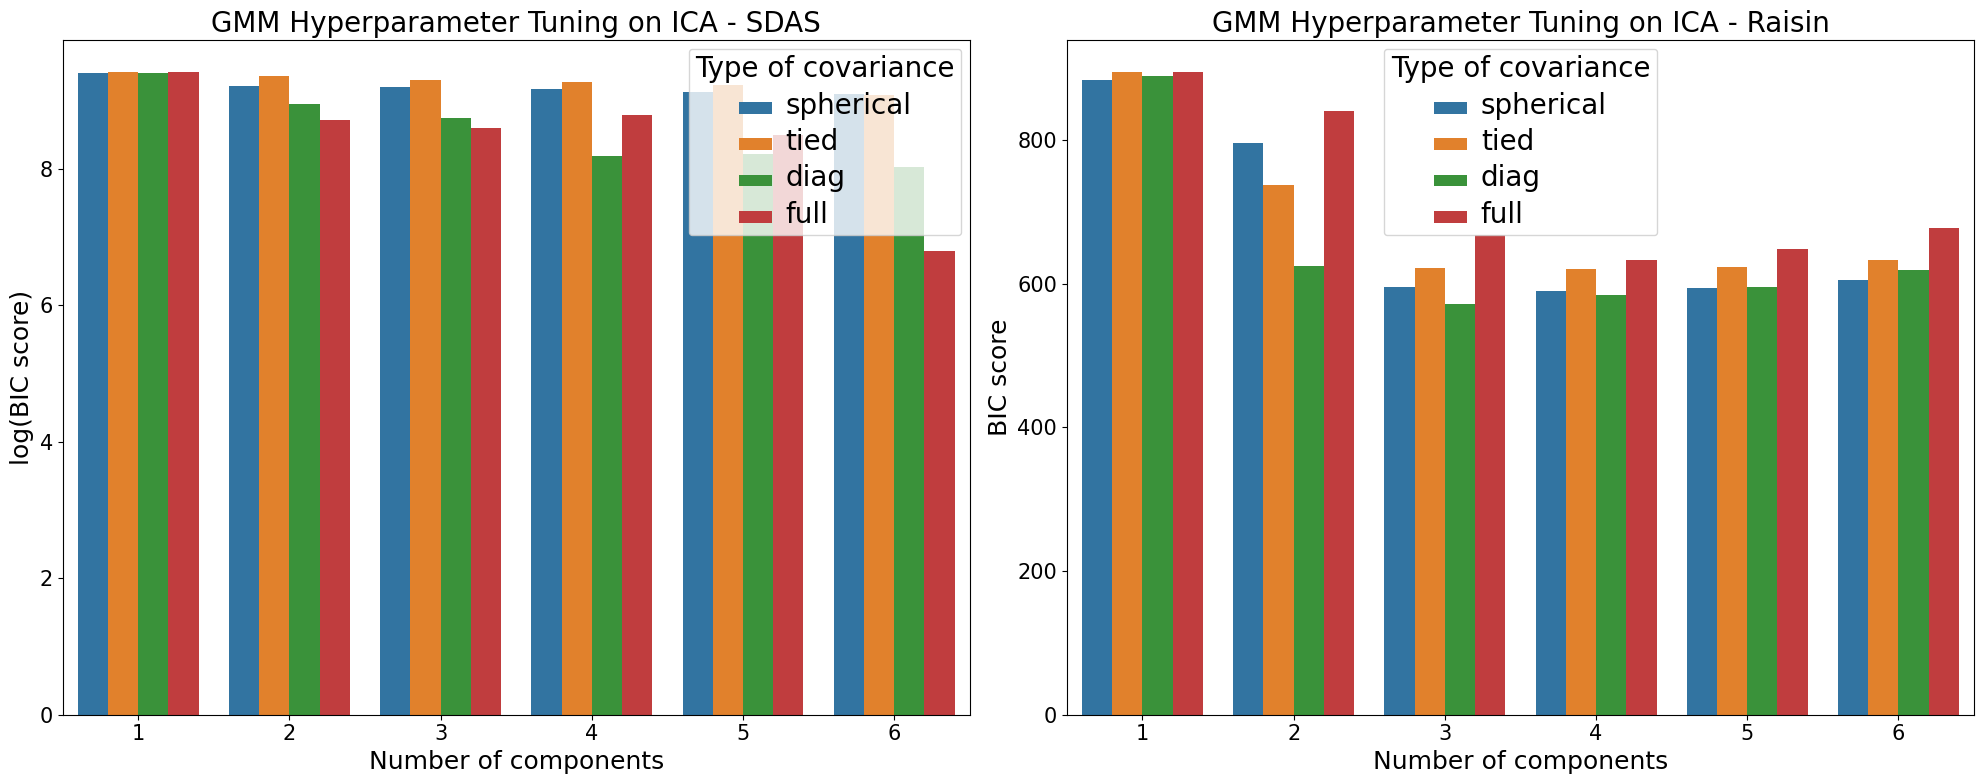

Best parameters for SDAS: {'classifier__covariance_type': 'full', 'classifier__n_components': 6}
Min BIC score for SDAS: 898.4339998202656
Best parameters for Raisin: {'classifier__covariance_type': 'diag', 'classifier__n_components': 3}
Min BIC score for Raisin: 571.0538582096322


In [132]:
reload_notebook_cell()



# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = pipeline_helpers.grid_search_gmm(ica_sdas_comp, [], "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = pipeline_helpers.grid_search_gmm(ica_raisin_comp, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_raisin["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning on ICA - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning on ICA - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(plt)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

In [134]:
# get the labels for the best model
best_gmm_sdas = pipelines.GMM_pipeline(ica_sdas_comp, CATEGORY_COLUMNS_UCML, n_components=best_params_sdas['classifier__n_components'], covariance_type=best_params_sdas['classifier__covariance_type'], random_state=42).fit(ica_sdas_comp)
best_gmm_raisin = pipelines.GMM_pipeline(ica_raisin_comp, [], n_components=best_params_raisin['classifier__n_components'], covariance_type=best_params_raisin['classifier__covariance_type'], random_state=42).fit(ica_raisin_comp)
gmm_labels_sdas_labels = best_gmm_sdas['classifier'].predict(ica_sdas_comp)
gmm_labels_raisin_labels = best_gmm_raisin['classifier'].predict(ica_raisin_comp)

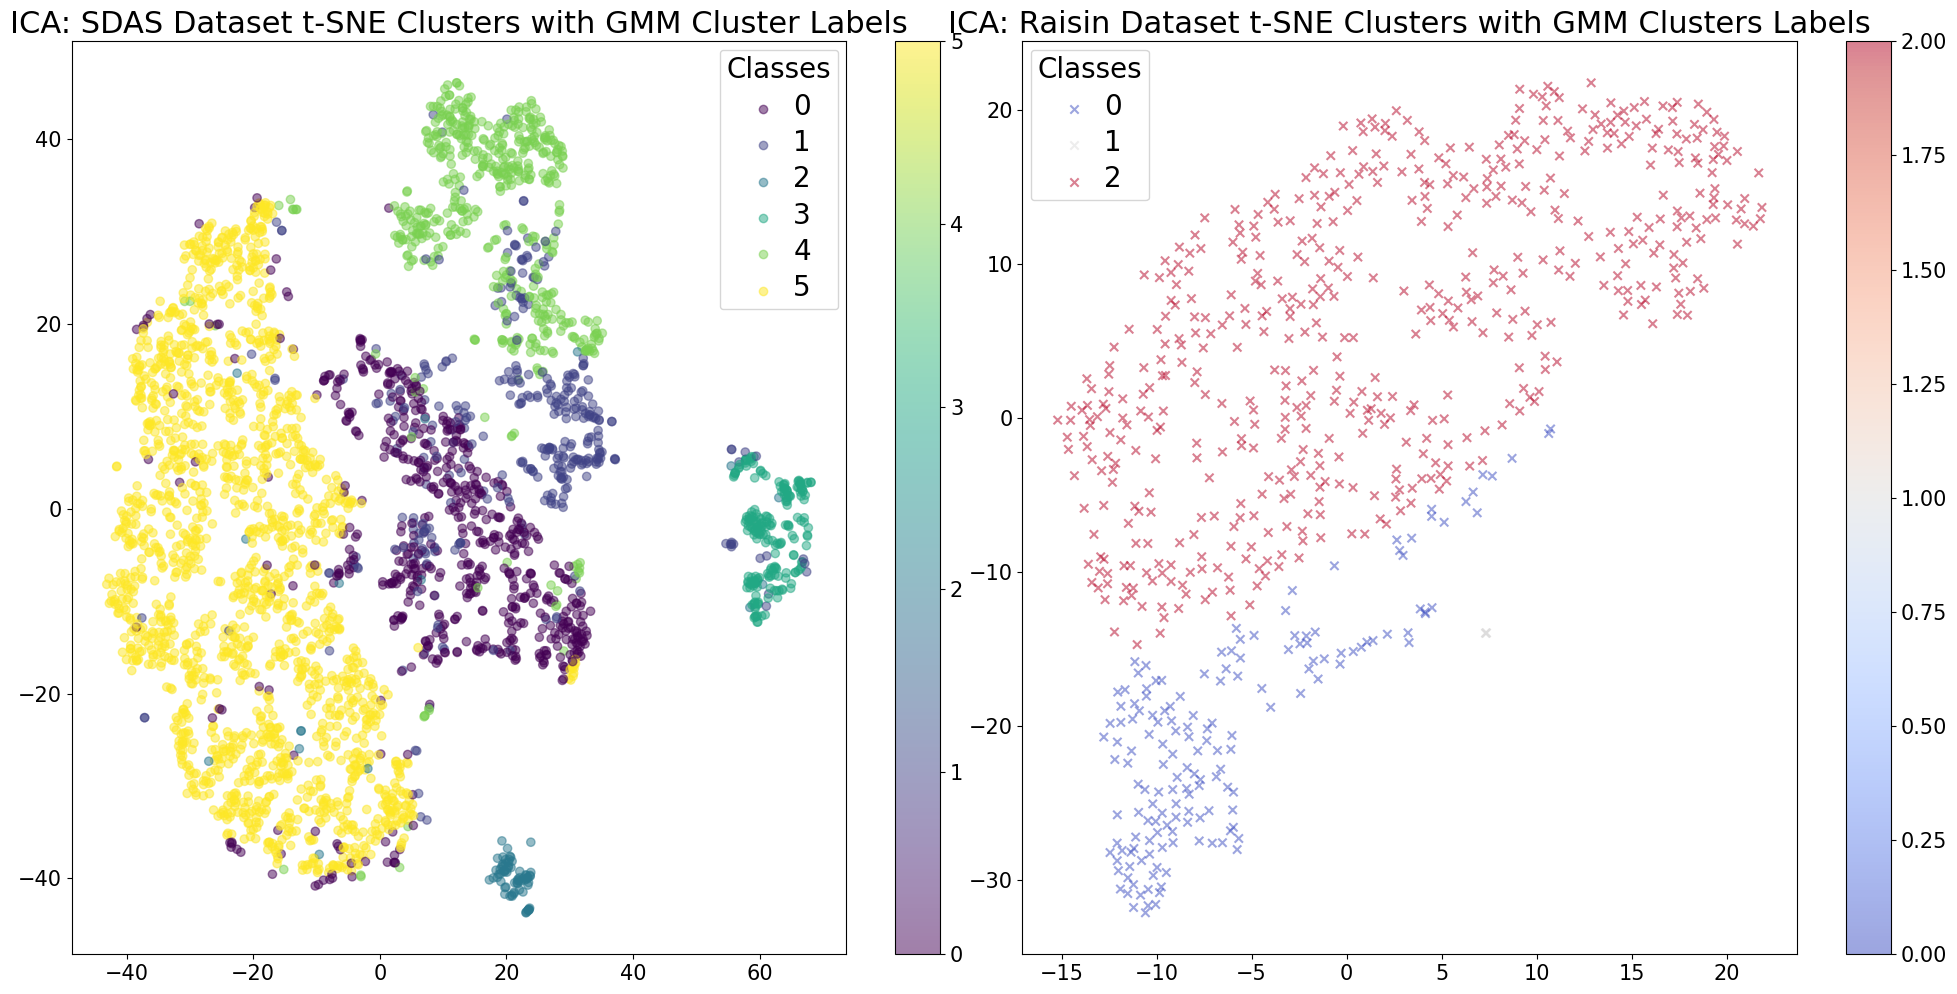

In [136]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(ica_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(ica_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(ica_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(ica_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("ICA: SDAS Dataset t-SNE Clusters with GMM Cluster Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=gmm_labels_sdas_labels, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(gmm_labels_sdas_labels)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("ICA: Raisin Dataset t-SNE Clusters with GMM Clusters Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=gmm_labels_raisin_labels, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(gmm_labels_raisin_labels)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt,
    15,
    17,
    12 * 1.34,
    12,
    1.3
) 
plt.show()

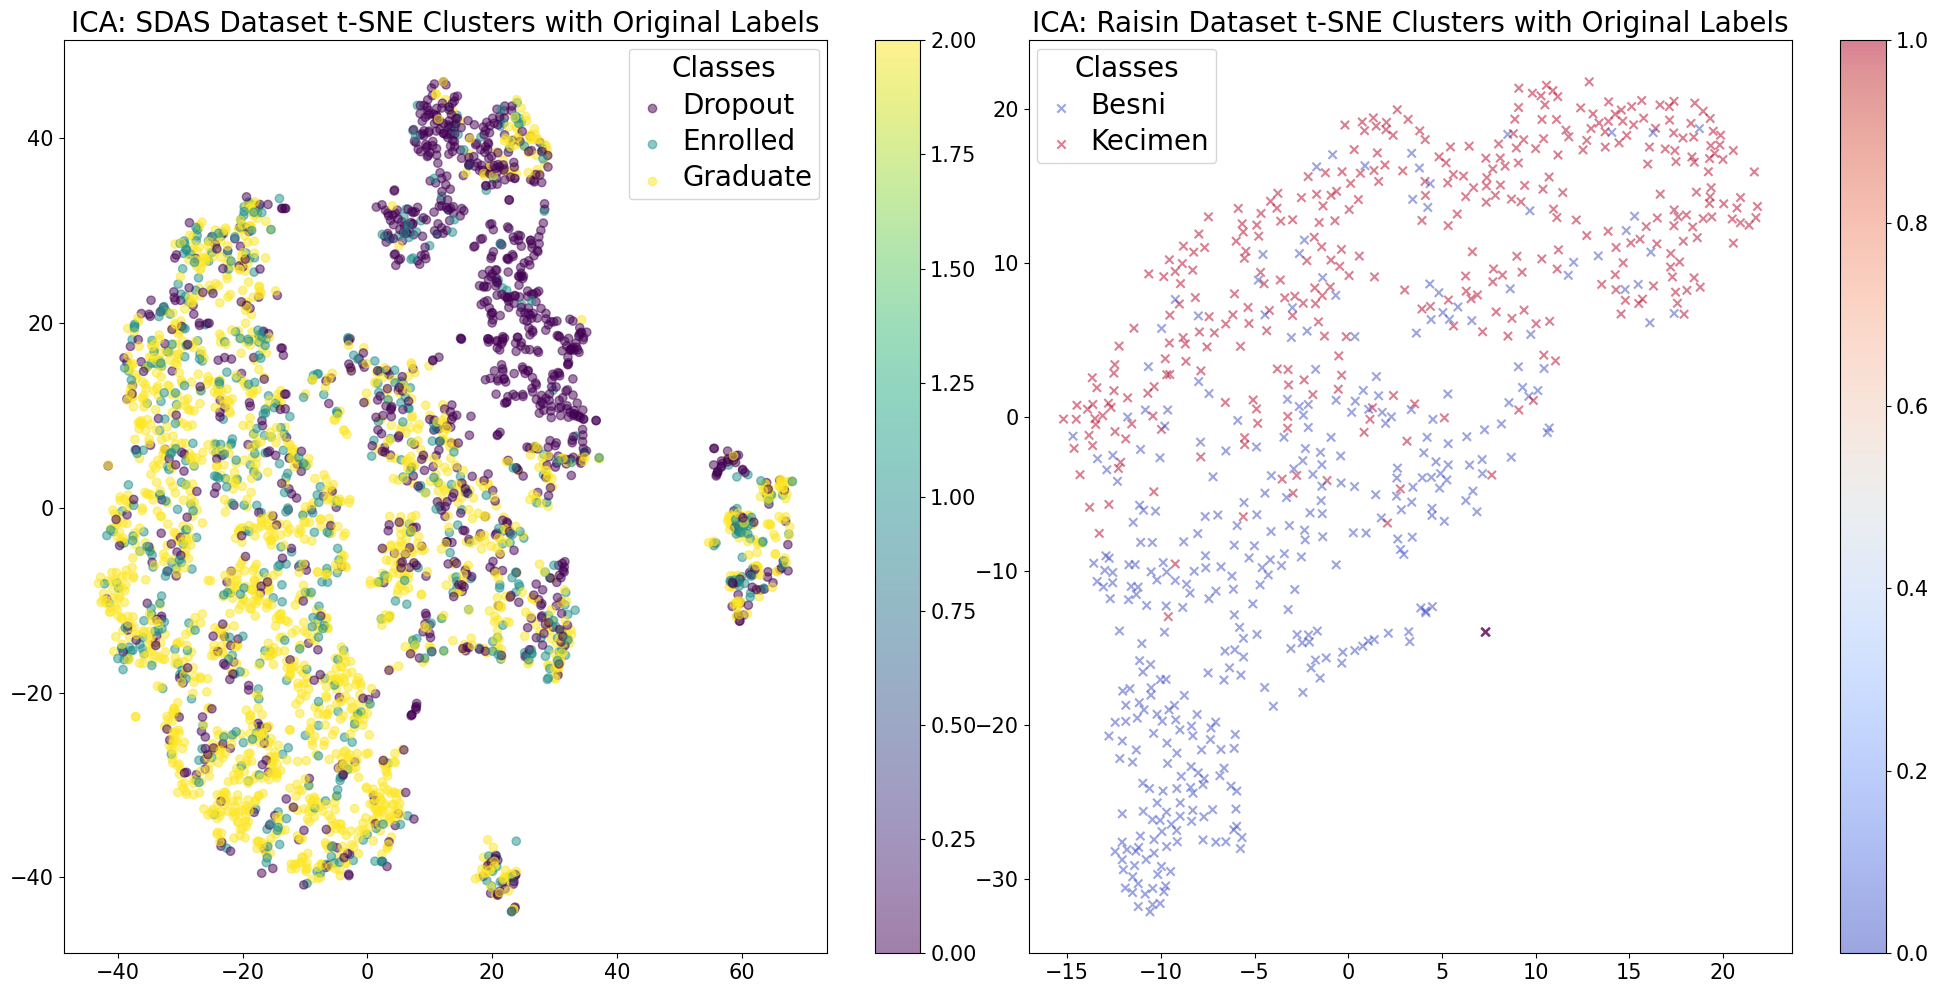

In [160]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(ica_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(ica_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(ica_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform( ica_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("ICA: SDAS Dataset t-SNE Clusters with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(y_train_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("ICA: Raisin Dataset t-SNE Clusters with Original Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(y_train_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt) 
plt.show()
